# IMA Project : underwater image restauration

#### Formulation du problème
Les appareils photo et caméras modernes sont capables de corriger les couleurs d'une image prise dans différentes conditions (par exemple lumière néon, soleil fort ou ciel couvert). Malgré les résultats souvent satisfasant des méthodes intégrées, elles ont beaucoup de mal à gérer les imags sous-marines, où la forte déformation chromatique s'ajoute à une diffusion optique de la lumière.

In [1]:
''' IMPORTS '''
#!pip install scikit-image
#!pwd
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from PIL import Image
from skimage import io, color

from tqdm import tqdm


In [2]:
''' FONCTIONS BASIQUES '''

def image(path):
    im = np.array(Image.open(path).copy())
    if len(im.shape)==2:
        return im[:,:]
    elif im.shape[2]==3 or im.shape[2]==4:
        return im[:,:,:3]
    else:
        raise ValueError('in \'image()\' function, image shape isn\'t 1/3/4 channels')

def display(im,title=''):
    if len(im.shape)==2:
        plt.imshow(im, cmap = 'gray')
        plt.title(title)
        plt.show()
    elif im.shape[2]==3 or im.shape[2]==4:
        plt.imshow(im)
        plt.title(title)
        plt.show()
    else:
        raise ValueError('in \'display()\' function, image shape isn\'t 1/3/4 channels')


## Fonctions

In [3]:
'''GRAYSCALE IMAGES'''
def Ghisto_smpl(im1,title=''):
    (histo,bins)=np.histogram(im1.reshape((-1,)),np.arange(0,256))
    plt.plot(histo,color='black')
    plt.title(title)
    plt.show()

def Ghisto_cum(im1,title=''):
    (histo,bins)=np.histogram(im1.reshape((-1,)),np.arange(0,256))
    histo=histo/histo.sum()
    histocum=histo.cumsum()
    plt.plot(histocum,color='black')
    plt.title(title)
    plt.show()

def Grescale2unit(im):
    im=im.astype('float64')
    m = im[:,:].min()
    M = im[:,:].max()
    if M!=m:
        im[:,:] = (im[:,:]-m)/(M-m)
    else:
        im[:,:] = (im[:,:]-im[:,:])+0.5
    return im

def Gunit2uint8(im):
    im[:,:] = 255*im[:,:]
    return im.astype('uint8')

def Gegalisation(im1):
    imres=np.zeros(im.shape)
    (histo,bins)=np.histogram(im1.reshape((-1,)),np.arange(0,256))
    histo = np.append(histo,0)
    histo=histo/histo.sum()
    histocum=histo.cumsum()
    imres[:,:]=histocum[np.uint8(im[:,:])]
    return Gunit2uint8(imres)

In [4]:
'''COLORED IMAGES'''

def rescale2unit(im):
    if len(im.shape)==2:
        return Grescale2unit(im)
    im=im.astype('float64')
    for i in range(3):
        m = im[:,:,i].min()
        M = im[:,:,i].max()
        if M!=m:
            im[:,:,i] = (im[:,:,i]-m)/(M-m)
        else:
            im[:,:,i] = (im[:,:,i]-im[:,:,i])+0.5
    return im

def unit2uint8(im):
    if len(im.shape)==2:
        return Gunit2uint8(im)
    for i in range(3):
        im[:,:,i] = 255*im[:,:,i]
    return im.astype('uint8')

def diagram_ab(im,title=''):
    im = color.rgb2lab(im)
    plt.scatter(im[:,:,1],im[:,:,2],color='blue')
    plt.scatter(0,0,color='red')
    plt.title(title)
    plt.show()

def histo_cum(im,title=''):
    if len(im.shape)==2:
        return Ghisto_cum(im,title)
    for i in range(3):
        im1 = im[:,:,i]
        (histo,bins)=np.histogram(im1.reshape((-1,)),np.arange(0,256))
        histo=histo/histo.sum()
        histocum=histo.cumsum()
        plt.plot(histocum,color=['red','green','blue'][i])
    plt.title(title)
    plt.show()

def histo_smpl(im,title=''):
    if len(im.shape)==2:
        return Ghisto_smpl(im,title)
    for i in range(3):
        im1 = im[:,:,i]
        (histo,bins)=np.histogram(im1.reshape((-1,)),np.arange(0,256))
        plt.plot(histo,color=['red','green','blue'][i])
    plt.title(title)
    plt.show()

## L'hypothèse du monde gris

In [5]:
def mgris(im, space='lab', filt='median'): # the article present median as more effective than mean
    if len(im.shape)==2:
        return im # l'image noir-et-blanc vérifie l'hypothèse du monde gris
    
    im = im.copy()
    
    if space == 'lab':
        im = color.rgb2lab(im)
    elif space != 'rgb':
        raise ValueError("'space' paramater should be 'rgb' or 'lab'")
    
    if filt == 'average':
        ref_0 = np.average(im[:,:,0])
        ref_1 = np.average(im[:,:,1])
        ref_2 = np.average(im[:,:,2])
    elif filt == 'median':
        ref_0 = np.median(im[:,:,0])
        ref_1 = np.median(im[:,:,1])
        ref_2 = np.median(im[:,:,2])
    else:
        raise ValueError("'filt' paramater should be 'average' or 'median'")
    
    if space == 'rgb':
        im[:,:,0] = 128 + (ref_0 - im[:,:,0])/2
        im[:,:,1] = 128 + (ref_1 - im[:,:,1])/2
        im[:,:,2] = 128 + (ref_2 - im[:,:,2])/2

    elif space == 'lab':
        l = im[:,:,0]
        a = im[:,:,1]-ref_1
        b = im[:,:,2]-ref_2
        im = np.stack((l,a,b), axis=-1)
        im = color.lab2rgb(im)
    return unit2uint8(im)
#! multiplying by 128 is a simple way to stretch the image histogram

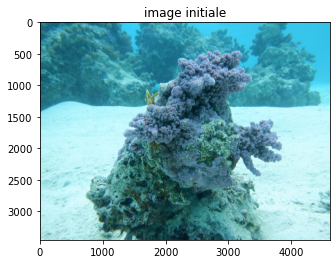

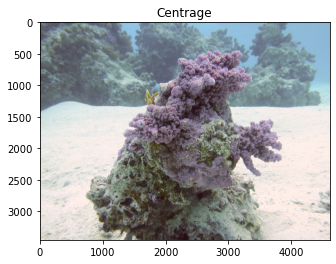

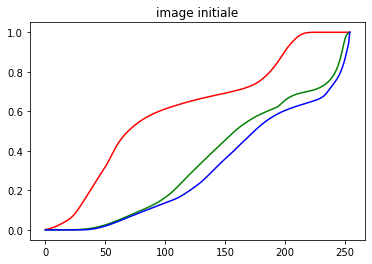

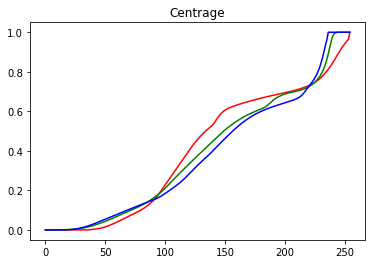

In [7]:
im = image('coraux_4.jpg')

display(im,'image initiale')

im2 = mgris(im)
display(im2, 'Centrage')

histo_cum(im,'image initiale')
histo_cum(im2,'Centrage')

## Egalisation

In [9]:
def egalisation(im):
    if len(im.shape)==2:
        return Gegalisation(im)
    
    imres=np.zeros(im.shape)
    for i in range(3):
        im1 = im[:,:,i]
        (histo,bins)=np.histogram(im1.reshape((-1,)),np.arange(0,256))
        histo = np.append(histo,0)
        histo=histo/histo.sum()
        histocum=histo.cumsum()
        imres[:,:,i]=histocum[np.uint8(im[:,:,i])]
    return unit2uint8(imres)

## Visualisation de la méthode de l'article 1: correction de la lumière

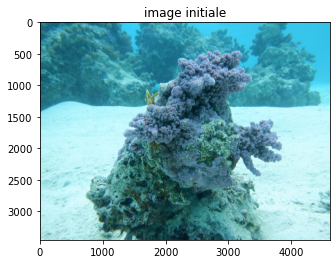

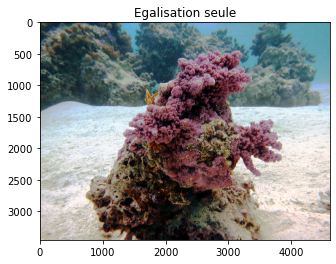

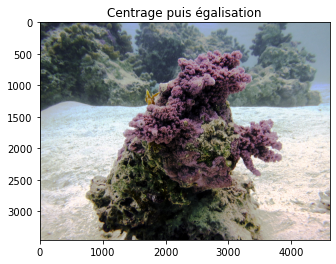

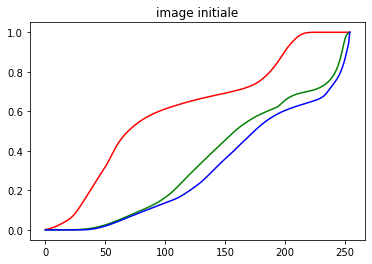

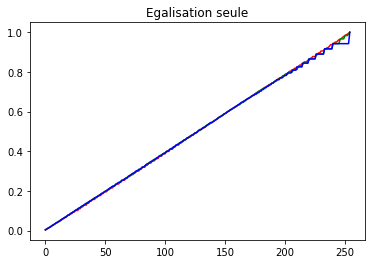

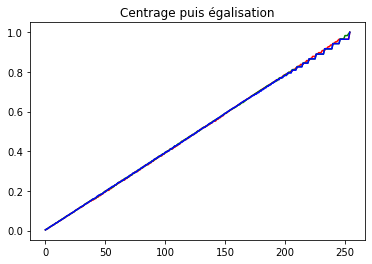

In [10]:
im = image('coraux_4.jpg')

display(im, 'image initiale')

im1 = egalisation(im)
display(im1,'Egalisation seule')

im2 = mgris(im)
im2 = egalisation(im2)
display(im2,'Centrage puis égalisation')

histo_cum(im, 'image initiale')
histo_cum(im1,'Egalisation seule')
histo_cum(im2,'Centrage puis égalisation')


# Restauration

## Wiener filter

In [11]:
def Gwiener(im,K,lamb=0):
    """lamb=0 donne le filtre inverse"""
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (ty,tx)=im.shape
    (yK,xK)=K.shape
    KK=np.zeros((ty,tx))
    KK[:yK,:xK]=K
    x2=tx/2
    y2=ty/2
    
    fX=np.concatenate((np.arange(0,x2+0.99),np.arange(-x2+1,-0.1)))
    fY=np.concatenate((np.arange(0,y2+0.99),np.arange(-y2+1,-0.1)))
    fX=np.ones((ty,1))@fX.reshape((1,-1))
    fY=fY.reshape((-1,1))@np.ones((1,tx))
    fX=fX/tx
    fY=fY/ty
    
    w2=fX**2+fY**2
    w=w2**0.5
    
    #tranformee de Fourier de l'image degradeee
    g=fft2(im)
    #transformee de Fourier du noyau
    k=fft2(KK)
    #fonction de mutilplication
    mul=np.conj(k)/(abs(k)**2+lamb*w2)
    #filtrage de wiener
    fout=g*mul
    
    # on effectue une translation pour une raison technique
    mm=np.zeros((ty,tx))
    y2=int(np.round(yK/2-0.5))
    x2=int(np.round(xK/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*(fft2(mm))))
    return out.astype('uint8')

def get_gau_ker(s):
    ss=int(max(3,2*np.round(2.5*s)+1))
    ms=(ss-1)//2
    X=np.arange(-ms,ms+0.99)
    y=np.exp(-X**2/2/s**2)
    out=y.reshape((ss,1))@y.reshape((1,ss))
    out=out/out.sum()
    return out


#### Restauring a grayscale image

In [12]:
'''GRAYSCALE IMAGES'''

def Gwiener_gauss(im,ker_dim,lamb):
    mask = get_gau_ker(ker_dim)
    return Gwiener(im,mask,lamb)

#im = image('images/05.jpg')
#display(im)

#im1 = Gwiener_gauss(im,ker_dim = 2,lamb = 50)
'''s'assurer que l'IMAGE choisie est GRISE'''
#display(im1)


"s'assurer que l'IMAGE choisie est GRISE"

#### Restauring a colored image

In [13]:
'''COLORED IMAGES'''
def wiener_gauss(im,ker_dim,lamb): # les paramètres sont des listes même pour une image grise : len=1
    if len(im.shape)==2:
        return Gwiener_gauss(im,ker_dim[0],lamb[0])
    
    im1=Image.fromarray(im)
    channels = im1.split()
    res = []

    for i in range(3):
        partim = channels[i]
        h,l = np.array(partim).shape
        if h%2==1 :
            h = h-1
        if l%2==1 :
            l = l-1

        partim = partim.resize((l,h))
        partim = np.array(partim)

        partim = Gwiener_gauss(partim,ker_dim[i],lamb[i])
        res.append(partim)

    resim = np.stack((res[0],res[1],res[2]), axis=-1)
    return unit2uint8(rescale2unit(resim))


## Dehazing filter

##### Nous allons remplacer la méthode de restauration de Wiener par une fonction 'dehaze', dont le code a été emprinté à un groupe travaillant sur la correction d'images avec brouillard.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os

from datetime import datetime
import time
#pip install opencv-python
import cv2

from tqdm import tqdm

from skimage.filters import median
from skimage.morphology import disk

from typing import Tuple

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
import scipy as sp
import scipy.ndimage

In [17]:
def box(img, r):
    """ O(1) box filter
        img - >= 2d image
        r   - radius of box filter
    """
    (rows, cols) = img.shape[:2]
    imDst = np.zeros_like(img)


    tile = [1] * img.ndim
    tile[0] = r
    imCum = np.cumsum(img, 0)
    imDst[0:r+1, :, ...] = imCum[r:2*r+1, :, ...]
    imDst[r+1:rows-r, :, ...] = imCum[2*r+1:rows, :, ...] - imCum[0:rows-2*r-1, :, ...]
    imDst[rows-r:rows, :, ...] = np.tile(imCum[rows-1:rows, :, ...], tile) - imCum[rows-2*r-1:rows-r-1, :, ...]

    tile = [1] * img.ndim
    tile[1] = r
    imCum = np.cumsum(imDst, 1)
    imDst[:, 0:r+1, ...] = imCum[:, r:2*r+1, ...]
    imDst[:, r+1:cols-r, ...] = imCum[:, 2*r+1 : cols, ...] - imCum[:, 0 : cols-2*r-1, ...]
    imDst[:, cols-r: cols, ...] = np.tile(imCum[:, cols-1:cols, ...], tile) - imCum[:, cols-2*r-1 : cols-r-1, ...]

    return imDst

def _gf_color(I, p, r, eps, s=None):
    """ Color guided filter
    I - guide image (rgb)
    p - filtering input (single channel)
    r - window radius
    eps - regularization (roughly, variance of non-edge noise)
    s - subsampling factor for fast guided filter
    """
    fullI = I
    fullP = p
    if s is not None:
        I = sp.ndimage.zoom(fullI, [1/s, 1/s, 1], order=1)
        p = sp.ndimage.zoom(fullP, [1/s, 1/s], order=1)
        r = round(r / s)

    h, w = p.shape[:2]
    N = box(np.ones((h, w)), r)

    mI_r = box(I[:,:,0], r) / N
    mI_g = box(I[:,:,1], r) / N
    mI_b = box(I[:,:,2], r) / N

    mP = box(p, r) / N

    # mean of I * p
    mIp_r = box(I[:,:,0]*p, r) / N
    mIp_g = box(I[:,:,1]*p, r) / N
    mIp_b = box(I[:,:,2]*p, r) / N

    # per-patch covariance of (I, p)
    covIp_r = mIp_r - mI_r * mP
    covIp_g = mIp_g - mI_g * mP
    covIp_b = mIp_b - mI_b * mP

    # symmetric covariance matrix of I in each patch:
    #       rr rg rb
    #       rg gg gb
    #       rb gb bb
    var_I_rr = box(I[:,:,0] * I[:,:,0], r) / N - mI_r * mI_r;
    var_I_rg = box(I[:,:,0] * I[:,:,1], r) / N - mI_r * mI_g;
    var_I_rb = box(I[:,:,0] * I[:,:,2], r) / N - mI_r * mI_b;

    var_I_gg = box(I[:,:,1] * I[:,:,1], r) / N - mI_g * mI_g;
    var_I_gb = box(I[:,:,1] * I[:,:,2], r) / N - mI_g * mI_b;

    var_I_bb = box(I[:,:,2] * I[:,:,2], r) / N - mI_b * mI_b;

    a = np.zeros((h, w, 3))
    for i in range(h):
        for j in range(w):
            sig = np.array([
                [var_I_rr[i,j], var_I_rg[i,j], var_I_rb[i,j]],
                [var_I_rg[i,j], var_I_gg[i,j], var_I_gb[i,j]],
                [var_I_rb[i,j], var_I_gb[i,j], var_I_bb[i,j]]
            ])
            covIp = np.array([covIp_r[i,j], covIp_g[i,j], covIp_b[i,j]])
            a[i,j,:] = np.linalg.solve(sig + eps * np.eye(3), covIp)

    b = mP - a[:,:,0] * mI_r - a[:,:,1] * mI_g - a[:,:,2] * mI_b

    meanA = box(a, r) / N[...,np.newaxis]
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, [s, s, 1], order=1)
        meanB = sp.ndimage.zoom(meanB, [s, s], order=1)

    q = np.sum(meanA * fullI, axis=2) + meanB

    return q


def _gf_gray(I, p, r, eps, s=None):
    """ grayscale (fast) guided filter
        I - guide image (1 channel)
        p - filter input (1 channel)
        r - window raidus
        eps - regularization (roughly, allowable variance of non-edge noise)
        s - subsampling factor for fast guided filter
    """
    if s is not None:
        Isub = sp.ndimage.zoom(I, 1/s, order=1)
        Psub = sp.ndimage.zoom(p, 1/s, order=1)
        r = round(r / s)
    else:
        Isub = I
        Psub = p


    (rows, cols) = Isub.shape

    N = box(np.ones([rows, cols]), r)

    meanI = box(Isub, r) / N
    meanP = box(Psub, r) / N
    corrI = box(Isub * Isub, r) / N
    corrIp = box(Isub * Psub, r) / N
    varI = corrI - meanI * meanI
    covIp = corrIp - meanI * meanP


    a = covIp / (varI + eps)
    b = meanP - a * meanI

    meanA = box(a, r) / N
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, s, order=1)
        meanB = sp.ndimage.zoom(meanB, s, order=1)

    q = meanA * I + meanB
    return q


def _gf_colorgray(I, p, r, eps, s=None):
    """ automatically choose color or gray guided filter based on I's shape """
    if I.ndim == 2 or I.shape[2] == 1:
        return _gf_gray(I, p, r, eps, s)
    elif I.ndim == 3 and I.shape[2] == 3:
        return _gf_color(I, p, r, eps, s)
    else:
        print("Invalid guide dimensions:", I.shape)


def guided_filter(I, p, r, eps, s=None):
    """ run a guided filter per-channel on filtering input p
        I - guide image (1 or 3 channel)
        p - filter input (n channel)
        r - window raidus
        eps - regularization (roughly, allowable variance of non-edge noise)
        s - subsampling factor for fast guided filter
    """
    if p.ndim == 2:
        p3 = p[:,:,np.newaxis]

    out = np.zeros_like(p3)
    for ch in range(p3.shape[2]):
        out[:,:,ch] = _gf_colorgray(I, p3[:,:,ch], r, eps, s)
    return np.squeeze(out) if p.ndim == 2 else out


def test_gf():
    import imageio
    cat = imageio.imread('cat.bmp').astype(np.float32) / 255
    tulips = imageio.imread('tulips.bmp').astype(np.float32) / 255

    r = 8
    eps = 0.05

    cat_smoothed = guided_filter(cat, cat, r, eps)
    cat_smoothed_s4 = guided_filter(cat, cat, r, eps, s=4)

    imageio.imwrite('cat_smoothed.png', cat_smoothed)
    imageio.imwrite('cat_smoothed_s4.png', cat_smoothed_s4)

    tulips_smoothed4s = np.zeros_like(tulips)
    for i in range(3):
        tulips_smoothed4s[:,:,i] = guided_filter(tulips, tulips[:,:,i], r, eps, s=4)
    imageio.imwrite('tulips_smoothed4s.png', tulips_smoothed4s)

    tulips_smoothed = np.zeros_like(tulips)
    for i in range(3):
        tulips_smoothed[:,:,i] = guided_filter(tulips, tulips[:,:,i], r, eps)
    imageio.imwrite('tulips_smoothed.png', tulips_smoothed)

In [18]:
# 4.1. Estimating the Transmission

def patch(image: np.ndarray, pixel: Tuple[int, int], halfsize: int = 2) -> np.ndarray:
    '''
    return: neighborhood of pixel with rayon = 2*halfsize + 1
    '''
    x, y = pixel
    # with borders treatment
    return image[max(0,x-halfsize):min(image.shape[0], x+halfsize),
             max(0,y-halfsize):min(image.shape[1], y+halfsize)]

def get_dark_channel(image: np.ndarray, pixel: Tuple[int, int]) -> int:
    '''
    return: the darkest pixel of 3 channels in the particular patch
    '''
    return min(patch(image, pixel).reshape(-1))

def transmission(image: np.ndarray, pixel: Tuple[int, int], A: Tuple[float, float, float], 
                 w: float, t0: float, halfsize: int) -> float:
    '''
    A - airlight
    w, t0 - hyperparameters
    '''
    norm_darkch = 255
    for c in range(image.shape[-1]):
        norm_darkch = min(norm_darkch, min(patch(image, pixel, halfsize)[:,:,c].reshape(-1))/A[c])
    return max(1 - w*norm_darkch, t0)


# 4.3 Recovering the Scene Radiance

def scene_radiance(image: np.ndarray, pixel: Tuple[int, int], 
                   A: Tuple[float, float, float], t: float) -> np.ndarray:
    return A + (image[pixel] - A)/t


# 4.4. Estimating the Atmospheric Light

def get_airlight(image: np.ndarray, thresh_top: int) -> Tuple[float, float, float]:
    pixels_dark_channel = {}
    print('1/3')
    for x in tqdm(range(image.shape[0])):
        for y in range(image.shape[1]):
            dark = get_dark_channel(image, (x,y))
            if dark in pixels_dark_channel:
                pixels_dark_channel[dark].append((x,y))
            else:
                pixels_dark_channel[dark] = [(x,y)]
    bright_dark_thresh = np.percentile(list(pixels_dark_channel.keys()), (1-thresh_top)*100)
    bright_darks = [dark for dark in pixels_dark_channel if dark >= bright_dark_thresh]
    intense, airlight_x_y = 0, (0, 0)
    for dark in bright_darks:
        for pixel in pixels_dark_channel[dark]:
            tmp = image[pixel].mean()
            if intense < tmp:
                airlight_x_y = pixel
                intense = tmp
    return image[airlight_x_y]

In [19]:
def dehaze(ima: np.ndarray, eps=0.01, r=2, w=0.95, t0=0.1, thresh_top=0.01, halfsize=2):
    ''' r = 4, 8, 20, 40, 64 en fonction de la taille de l'image (a peu pres)
        w = 0.8, 0.75, 0.95 = quantité de diffusion optique qu'on garde
        half-size = 2...10 en fonction de la taille de l'image également
    '''
    print('dehaze...')
    start = time.time()
    fl_ima = ima.astype(np.float32)
    A = get_airlight(fl_ima, thresh_top)

    n, m, l = fl_ima.shape
    fl_J = np.zeros([n, m, l])
    t_map = np.zeros([n, m])
    print('2/3')
    for x in tqdm(range(n)):
        for y in range(m):
            pixel = (x, y)
            t = transmission(fl_ima, pixel, A, w, t0, halfsize=halfsize)
            t_map[pixel] = t
    
#    t_map_filtered = guidedFilter(src=np.float32(t_map), 
#                                   guide=np.float32(ima.mean(axis=-1)), radius=r, eps=eps)
    t_map_filtered = guided_filter(p=np.float32(t_map), 
                                   I=np.float32(ima.mean(axis=-1)), r=r, eps=eps)
    print('3/3')
    for x in tqdm(range(n)):
        for y in range(m):
            pixel = (x,y)
            t = t_map_filtered[pixel]
            fl_J[pixel] = scene_radiance(fl_ima, pixel, A, t)

    J = fl_J.astype(np.uint8)
#    J = (fl_J - min(fl_J.reshape(-1)))/(max(fl_J.reshape(-1)))
    tlapse = time.time() - start
    print('Temps de dehaze : {}s'.format(int(tlapse)))
    return J #, t_map, t_map_filtered

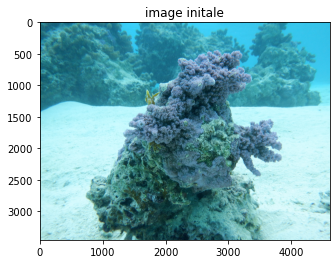

dehaze...
1/3


100%|███████████████████████████████████████████████████████████████████████████████████████████| 3456/3456 [04:16<00:00, 13.50it/s]


2/3


  5%|████▏                                                                                       | 157/3456 [01:14<26:06,  2.11it/s]


KeyboardInterrupt: 

In [20]:
'''TESTNG DEHAZE FILTER ON UNDERWATER IMAGES'''

im = image('coraux_4.jpg')
display(im,'image initale')

resim = dehaze(im, r=40, w=0.4, halfsize=6)
display(resim,'Dehaze seul')

## Visualisation de la correction de la diffusion optique avec *dehaze*

In [ ]:
im = image('coraux_4.jpg')
display(im,'image initiale')

im1 = mgris(im)
im1 = egalisation(im1)
display(im1, 'couleurs corrigées')

im2 = wiener_gauss(im1, ker_dim = [2]*3, lamb = [1]*3)
display(im2,'Wiener')

im3 = wiener_gauss(im1, ker_dim = [5]*3, lamb = [4]*3)
display(im3,'Wiener')


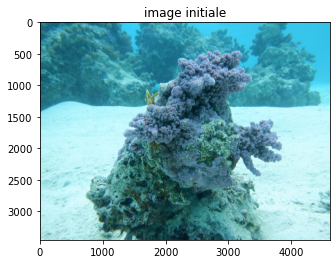

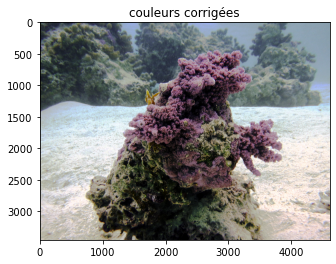

dehaze...
1/3


100%|███████████████████████████████████████████████████████████████████████████████████████████| 3456/3456 [04:31<00:00, 12.73it/s]


2/3


100%|███████████████████████████████████████████████████████████████████████████████████████████| 3456/3456 [27:32<00:00,  2.09it/s]


3/3


100%|███████████████████████████████████████████████████████████████████████████████████████████| 3456/3456 [02:25<00:00, 23.83it/s]


Temps de dehaze : 2086s


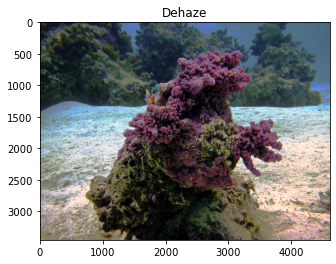

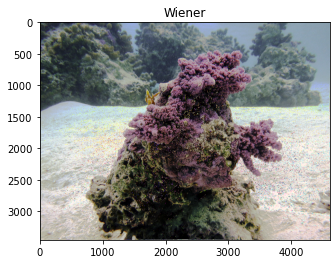

In [21]:
im = image('coraux_4.jpg')
display(im,'image initiale')

im1 = mgris(im)
im1 = egalisation(im1)
display(im1, 'couleurs corrigées')

im2 = dehaze(im1, r=64, w=0.7, halfsize= 6)
display(im2,'Dehaze')

im3 = wiener_gauss(im1, ker_dim = [2]*3, lamb = [3]*3)
display(im3,'Wiener')

# $ \quad \quad \quad \mathscr{The \quad End} $